In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import pycbc.noise
import pycbc.psd as psd
from pycbc.detector import Detector
from astropy.cosmology import z_at_value,Planck15
import astropy.units as u
from pycbc.waveform import td_approximants, fd_approximants
from pycbc import types, fft, waveform
from scipy.special import gammainc
import gwinc
from os.path import join
import tqdm
from scipy.stats import chi2,ncx2

blue='#08519c'
green='#33a02c'
red='#e31a1c'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
# Function to calculate PSD shamelessly copied from the following:
# https://git.ligo.org/post-o5/post-o5-report/-/blob/e8ad18ea098fbbb17035dd110488ab11124ac38c/code/lib.py
def calc_gwinc_budget(f_Hz, ifo_name, ifo_dir, bname=None):
    budget = gwinc.load_budget(
        join(ifo_dir, ifo_name + '.yaml'), f_Hz, bname=bname)
    if 'AlGaAs' in ifo_name:
        inherit_budget = gwinc.load_budget(
            join(ifo_dir, 'AplusNoCoatTO'), freq=f_Hz, bname=bname)
    elif 'tech_noise' in ifo_name:
        inherit_budget = gwinc.load_budget(
            join(ifo_dir, 'AplusTechNoise'), freq=f_Hz, bname=bname)
    else:
        inherit_budget = budget
    return inherit_budget.run(ifo=budget.ifo)

# Compute A-sharp PSD
fmin = 3
fmax = 6e3
npts = 5000
f_Hz = np.logspace(np.log10(fmin), np.log10(fmax), npts)
traces = calc_gwinc_budget(f_Hz,'Asharp_AlGaAs','./../sensitivity-curves/ifos/')

# Convert to pycbc FrequencySeries object
psd_delta_f = 1./256
psd_length = int(4096./psd_delta_f)
psd_low_frequency_cutoff = 5.
HL_psd = pycbc.psd.from_numpy_arrays(f_Hz,traces.psd,psd_length,psd_delta_f,psd_low_frequency_cutoff)

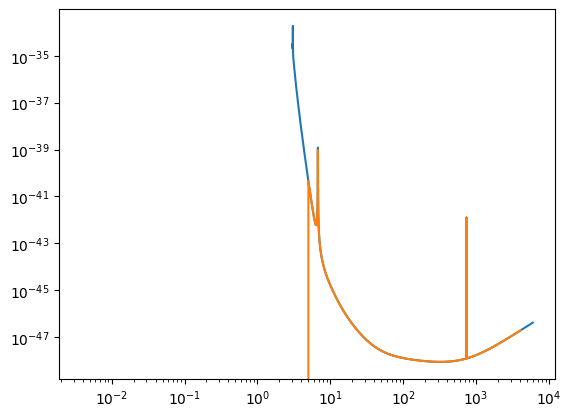

In [3]:
fig,ax = plt.subplots()
ax.plot(f_Hz,traces.psd)
ax.plot(HL_psd.sample_frequencies.data,HL_psd.data)
ax.set_xscale('log')
ax.set_yscale('log')

In [9]:
# Population parameters

# BBH
bbh_R_ref = 25.
bbh_min_m1 = 5.
bbh_max_m1 = 100.
bbh_alpha_m1 = -3.
bbh_min_m2 = 2.
bbh_alpha_m2 = 1.
bbh_zMax = 5

# BNS
bns_R_ref = 170.
bns_zMax = 0.75

# NSBH
nsbh_R_ref = 30.
nsbh_zMax = 1.5

# Merger rate model
z_alpha = 2.7
z_peak = 2.
z_beta = 3.

def fz(z,alpha,beta,zp):
    """
    Function implementing a Madau+Dickinson-like star formation rate.
    Note that this function computes only the *shape* of the SFR, and does
    not include a normalization
    """
    f_z = (1.+z)**alpha/(1.+((1.+z)/(1.+zp))**(alpha+beta))
    return f_z

def draw_bbh_masses():
    """
    Function to randomly draw two masses from our toy bbh distribution
    """
    c_m1 = np.random.random()
    c_m2 = np.random.random()
    m1 = (bbh_min_m1**(1.+bbh_alpha_m1) + c_m1*(bbh_max_m1**(1.+bbh_alpha_m1)-bbh_min_m1**(1.+bbh_alpha_m1)))**(1./(1.+bbh_alpha_m1))
    m2 = (bbh_min_m2**(1.+bbh_alpha_m2) + c_m2*(m1**(1.+bbh_alpha_m2)-bbh_min_m2**(1.+bbh_alpha_m2)))**(1./(1.+bbh_alpha_m2)) 
    return m1,m2

def draw_bns_masses():
    """
    Function to randomly draw two masses from our toy bns distribution
    """
    return 1.4,1.4

def draw_nsbh_masses():
    """
    Function to randomly draw two masses from our toy bbh distribution
    """
    c_m1 = np.random.random()
    m1 = (bbh_min_m1**(1.+bbh_alpha_m1) + c_m1*(bbh_max_m1**(1.+bbh_alpha_m1)-bbh_min_m1**(1.+bbh_alpha_m1)))**(1./(1.+bbh_alpha_m1))
    return m1,1.4

def draw_params(type='BBH'):

    """
    Helper function to randomly draw sets of CBC parameters.
    Used by `draw_hopeless()` and `draw_certain()` below to generate additional undetectable CBCs
    to assist in neural network training.

    Parameters
    ----------
    DL_max : `float`
        Maximum distance to consider, in Mpc (default 15e3)
    dist : `str`
        If 'uniform' (default), will draw uniform source-frame component masses. Otherwise
        will draw masses according to O3 injection distribution

    Returns
    -------
    paramDict : `dict`
        Dictionary containing randomly drawn component masses, Cartesian spins, sky position,
        source orientation, distance, and time. Note that the provided masses are in the *detector frame*.
    """

    # Draw masses and spin magnitudes
    if type=="BBH":
        m1,m2 = draw_bbh_masses()
        a1 = np.random.random()
        a2 = np.random.random()
        zMax = bbh_zMax

    elif type=="BNS":
        m1,m2 = draw_bns_masses()
        a1 = 0.1*np.random.random()
        a2 = 0.1*np.random.random()    
        zMax = bns_zMax

    elif type=="NSBH":
        m1,m2 = draw_nsbh_masses()
        a1 = np.random.random()
        a2 = 0.1*np.random.random() 
        zMax = nsbh_zMax

    # Isotropic spins
    cost1 = 2.*np.random.random()-1.
    cost2 = 2.*np.random.random()-1.
    phi1 = 2.*np.pi*np.random.random()
    phi2 = 2.*np.pi*np.random.random()

    # Isotropic sky position and orientation
    cos_inc = 2.*np.random.random()-1.
    ra = 2.*np.pi*np.random.random()
    sin_dec = 2.*np.random.random()-1.
    pol = 2.*np.pi*np.random.random()

    # Draw redshifts
    z_grid = np.linspace(0,zMax,300)
    dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(z_grid).to(u.Gpc**3*u.sr**(-1)).value
    p_z_grid = dVdz_grid*fz(z_grid,z_alpha,z_beta,z_peak)/(1.+z_grid)
    c_z_grid = np.cumsum(p_z_grid)
    c_z_grid /= c_z_grid[-1]
    z = np.interp(np.random.random(),c_z_grid,z_grid)
    DL = Planck15.luminosity_distance(z).to(u.Mpc).value

    # Get a random time across O3
    O3_start = 1238166018
    O3_end = 1269363618
    time = np.random.random()*(O3_end-O3_start) + O3_start
    
    # Package it all in a dictionary and return
    # Note that these dictionary keys need to correspond to parameters expected by `get_fd_waveform` in `get_snrs()` below
    paramDict = {'mass1':m1*(1.+z),
                'mass2':m2*(1.+z),
                'distance':DL,
                'redshift':z,
                'spin1x':a1*np.sqrt(1.-cost1**2)*np.cos(phi1),
                'spin1y':a1*np.sqrt(1.-cost1**2)*np.sin(phi1),
                'spin1z':a1*cost1,
                'spin2x':a2*np.sqrt(1.-cost2**2)*np.cos(phi2),
                'spin2y':a2*np.sqrt(1.-cost2**2)*np.sin(phi2),
                'spin2z':a2*cost2,
                'right_ascension':ra,
                'declination':np.arcsin(sin_dec),
                'polarization':pol,
                'inclination':np.arccos(cos_inc),
                'time':time}

    return paramDict

def get_snrs(paramDict,H1_psd):

    """
    Function to compute the expected SNR of a BBH in O3.
    Used in conjunction with `draw_hopeless()` defined below to generate additional hopeless injections
    to assist in neural network training.

    Parameters
    ----------
    paramDict : `dict`
        Dictionary of BBH parameters, as produced by `draw_params()`.
    H_psd : `pycbc.types.frequencyseries.FrequencySeries`
        Frequency series representing H1 O3 PSD
    L_psd : `pycbc.types.frequencyseries.FrequencySeries`
        Frequency series representing L1 O3 PSD
        
    Returns
    -------
    snr : `float`
        H1L1 network SNR expected from the given set of BBH parameters
    """

    # Generate waveform
    delta_f=1./16.
    sptilde, sctilde = waveform.get_fd_waveform(approximant="IMRPhenomPv2",
                                                template=paramDict,
                                                delta_f=delta_f,
                                                f_lower=5.)

    # Project onto detectors
    H1 = Detector("H1")
    L1 = Detector("L1")
    Fhp,Fhc = H1.antenna_pattern(paramDict['right_ascension'],paramDict['declination'],paramDict['polarization'],paramDict['time'])
    Flp,Flc = L1.antenna_pattern(paramDict['right_ascension'],paramDict['declination'],paramDict['polarization'],paramDict['time'])
    h_H1 = Fhp*sptilde + Fhc*sctilde
    h_L1 = Flp*sptilde + Flc*sctilde
    
    # Project onto detectors
    H1 = Detector("H1")
    L1 = Detector("L1")
    Fhp,Fhc = H1.antenna_pattern(paramDict['right_ascension'],paramDict['declination'],paramDict['polarization'],paramDict['time'])
    Flp,Flc = L1.antenna_pattern(paramDict['right_ascension'],paramDict['declination'],paramDict['polarization'],paramDict['time'])
    h_H1 = Fhp*sptilde + Fhc*sctilde
    h_L1 = Flp*sptilde + Flc*sctilde

    # Interpolate PSDs
    # If PSD extends to higher frequencies than the GW signal, trim as necessary
    psd_H1_interpolated = psd.interpolate(H1_psd,h_H1.delta_f)
    if len(psd_H1_interpolated)>len(h_H1):
        psd_H1_interpolated = psd.interpolate(H1_psd,h_H1.delta_f)[:len(h_H1)]
    else:
        psd_H1_interpolated_tmp = types.FrequencySeries(types.zeros(len(h_H1)),delta_f=h_H1.delta_f)
        psd_H1_interpolated_tmp[0:len(psd_H1_interpolated)] = psd_H1_interpolated
        psd_H1_interpolated = psd_H1_interpolated_tmp

    # Compute expected SNRs and use to draw random observed network SNR from non-central chi-squared distribution
    # Note that PSDs are reported as identically zero in regions where they are in fact undefined,
    # so cut on frequencies at which PSDs are above zero
    snr_H1_sq = 4.*h_H1.delta_f*np.sum(np.array(np.abs(h_H1)**2/psd_H1_interpolated)[psd_H1_interpolated[()]>0.])
    snr_L1_sq = 4.*h_L1.delta_f*np.sum(np.array(np.abs(h_L1)**2/psd_H1_interpolated)[psd_H1_interpolated[()]>0.])
    network_snr_sq = ncx2.rvs(2,snr_H1_sq+snr_L1_sq)
    return np.sqrt(network_snr_sq)

def detection_rate(zMax,nFound,nTotal,R_ref,z_ref):

    """
    Helper function to compute inferred detection rates, given a certain number of found injections
    and total trials. R_ref is the total source-frame volumetric rate at z=0.2
    """

    # Compute total integrated detector-frame rate
    z_grid = np.linspace(0,zMax,1000)
    dVdz_grid = 4.*np.pi*Planck15.differential_comoving_volume(z_grid).to(u.Gpc**3*u.sr**(-1)).value
    f_z_integral = np.trapz(dVdz_grid*fz(z_grid,z_alpha,z_beta,z_peak)/(1.+z_grid),z_grid)
    R_tot = R_ref*(f_z_integral/fz(z_ref,z_alpha,z_beta,z_peak))

    # Estimated detection probability
    p_det = nFound/nTotal
    
    # Yearly detection rate
    R_det = R_tot*p_det

    # Compute variance in expected number of detections, and corresponding uncertainty on p_det
    var_nFound = nTotal*p_det*(1.-p_det)
    p_det_uncertainty = np.sqrt(var_nFound)/nTotal

    return p_det,R_det,R_tot*p_det_uncertainty

In [13]:
bbh_nFound = 0
bbh_nTotal = 3000
highest_z = 0
for i in tqdm.tqdm(range(bbh_nTotal)):
    
    x = draw_params('BBH')
    network_snr = get_snrs(x,HL_psd)
    if network_snr>10:
        bbh_nFound += 1
        highest_z = max(highest_z,x['redshift'])

bbh_p_det,bbh_R_det,bbh_R_det_uncertainty = detection_rate(bbh_zMax,bbh_nFound,bbh_nTotal,bbh_R_ref,0.2)
print(bbh_p_det,bbh_R_det,bbh_R_det_uncertainty)
print(highest_z)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:24<00:00,  9.25it/s]

0.05266666666666667 3334.074637377933 258.1654875182279
3.3689804629391094


In [10]:
bns_nFound = 0
bns_nTotal = 5000
highest_z = 0
for i in tqdm.tqdm(range(bns_nTotal)):
    
    x = draw_params('BNS')
    network_snr = get_snrs(x,HL_psd)
    if network_snr>10:
        bns_nFound += 1
        highest_z = max(highest_z,x['redshift'])

bns_p_det,bns_R_det,bns_R_det_uncertainty = detection_rate(bns_zMax,bns_nFound,bns_nTotal,bns_R_ref,0.)
print(bns_p_det,bns_R_det,bns_R_det_uncertainty)

  0%|                                                                                                                                         | 0/5000 [00:00<?, ?it/s]/opt/miniconda3/envs/post-O5-rates/lib/python3.8/site-packages/pycbc/types/array.py:383: RuntimeWarning: divide by zero encountered in divide
  return self._data / other
/opt/miniconda3/envs/post-O5-rates/lib/python3.8/site-packages/pycbc/types/array.py:383: RuntimeWarning: invalid value encountered in divide
  return self._data / other
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:05<00:00, 10.29it/s]

0.0118 346.71138002432895 44.870872629629545


In [11]:
nsbh_nFound = 0
nsbh_nTotal = 5000
highest_z = 0
for i in tqdm.tqdm(range(nsbh_nTotal)):
    
    x = draw_params('NSBH')
    network_snr = get_snrs(x,HL_psd)
    if network_snr>10:
        nsbh_nFound += 1
        highest_z = max(highest_z,x['redshift'])

nsbh_p_det,nsbh_R_det,nsbh_R_det_uncertainty = detection_rate(nsbh_zMax,nsbh_nFound,nsbh_nTotal,nsbh_R_ref,0.)
print(nsbh_p_det,nsbh_R_det,nsbh_R_det_uncertainty)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:55<00:00,  5.98it/s]

0.0102 334.5181169030414 46.60239965985216


In [14]:
print("BBH detection rate (1/yr):\t{0:.1e} +/- {1:.1e}".format(bbh_R_det,bbh_R_det_uncertainty))
print("BNS detection rate (1/yr):\t{0:.1e} +/- {1:.1e}".format(bns_R_det,bns_R_det_uncertainty))
print("NSBH detection rate (1/yr):\t{0:.1e} +/- {1:.1e}".format(nsbh_R_det,nsbh_R_det_uncertainty))

BBH detection rate (1/yr):	3.3e+03 +/- 2.6e+02
BNS detection rate (1/yr):	3.5e+02 +/- 4.5e+01
NSBH detection rate (1/yr):	3.3e+02 +/- 4.7e+01
